In [1]:
from collections import defaultdict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import seaborn as sns
import sklearn.metrics as skm
import sklearn.utils as skut
import sklearn.preprocessing as skpp
import time
import warnings

from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, f1_score
import condo

In [2]:
datapath = "/Users/calvinm/sandbox/JointMDS/datasets/SNARE"
Xs = np.load(f"{datapath}/scatac_feat.npy")
Xt = np.load(f"{datapath}/scrna_feat.npy")
Zs = np.loadtxt(f"{datapath}/SNAREseq_atac_types.txt").astype(int).astype(str).reshape(-1, 1)
Zt = np.loadtxt(f"{datapath}/SNAREseq_rna_types.txt").astype(int).astype(str).reshape(-1, 1)

Xs = skpp.Normalizer().fit_transform(Xs)
Xt = skpp.Normalizer().fit_transform(Xt)

# paired-sample info
Ys = np.arange(Xs.shape[0]).astype(str).reshape(-1, 1)
Yt = np.arange(Xt.shape[0]).astype(str).reshape(-1, 1)

transform_type = 'affine'

minfos = [
    #('Gaussian OT', partial(condo.AdapterGaussianOT, transform_type=transform_type)), 
    ('MMD', partial(condo.AdapterMMD, transform_type=transform_type, verbose=0)),
    #('ConDo Gaussian KLD', partial(condo.ConDoAdapterKLD, transform_type=transform_type)),
    ('ConDo MMD', partial(condo.ConDoAdapterMMD, transform_type=transform_type, verbose=0)),
]
num_random = 10
n_pairs_list = [5, 10, 20, 50, 100]
clf_train = 900

In [3]:
for mname, mfunc in minfos:
    adapter = mfunc()
    if 'ConDo' in mname:
        adapter.fit(Xs, Xt, Zs, Zt)
    else:
        adapter.fit(Xs, Xt)
    adaptXs = adapter.transform(Xs)

    ch_pair = skm.calinski_harabasz_score(
        np.concatenate([adaptXs, Xt], axis=0),
        labels=np.concatenate([Ys.flatten(), Yt.flatten()], axis=0),
    )
    ch_celltype = skm.calinski_harabasz_score(
        np.concatenate([adaptXs, Xt], axis=0),
        labels=np.concatenate([Zs.flatten(), Zt.flatten()], axis=0),
    )
    sil_pair = skm.silhouette_score(
        np.concatenate([adaptXs, Xt], axis=0),
        labels=np.concatenate([Ys.flatten(), Yt.flatten()], axis=0),
    )
    sil_celltype = skm.silhouette_score(
        np.concatenate([adaptXs, Xt], axis=0),
        labels=np.concatenate([Zs.flatten(), Zt.flatten()], axis=0),
    )
    print(f"{mname}\t CH-pair:{ch_pair:.4f} Sil-pair:{sil_pair:.4f} CH-cell:{ch_celltype:.4f} Sil-cell:{sil_celltype:.4f}") 

MMD	 CH-pair:4.0354 Sil-pair:-0.4550 CH-cell:1533.4683 Sil-cell:0.4592
ConDo MMD	 CH-pair:5.9097 Sil-pair:-0.4425 CH-cell:1872.0402 Sil-cell:0.4930


In [4]:
chs_pair = {mname: [] for mname, _ in minfos}
chs_celltype = {mname: [] for mname, _ in minfos}
sils_pair = {mname: [] for mname, _ in minfos}
sils_celltype = {mname: [] for mname, _ in minfos}

for rix in range(num_random):
    rng = skut.check_random_state(rix)
    ixs = rng.choice(Xs.shape[0], size=int(0.5*Xs.shape[0]), replace=False)
    ixt = rng.choice(Xt.shape[0], size=int(0.5*Xt.shape[0]), replace=False)

    for mname, mfunc in minfos:
        adapter = mfunc()
        if 'ConDo' in mname:
            adapter.fit(Xs[ixs, :], Xt[ixt, :], Zs[ixs, :], Zt[ixt, :])
        else:
            adapter.fit(Xs[ixs, :], Xt[ixt, :])
        adaptXs = adapter.transform(Xs)
    
        chs_pair[mname].append(skm.calinski_harabasz_score(
            np.concatenate([adaptXs, Xt], axis=0),
            labels=np.concatenate([Ys.flatten(), Yt.flatten()], axis=0),
        ))
        chs_celltype[mname].append(skm.calinski_harabasz_score(
            np.concatenate([adaptXs, Xt], axis=0),
            labels=np.concatenate([Zs.flatten(), Zt.flatten()], axis=0),
        ))
        sils_pair[mname].append(skm.silhouette_score(
            np.concatenate([adaptXs, Xt], axis=0),
            labels=np.concatenate([Ys.flatten(), Yt.flatten()], axis=0),
        ))
        sils_celltype[mname].append(skm.silhouette_score(
            np.concatenate([adaptXs, Xt], axis=0),
            labels=np.concatenate([Zs.flatten(), Zt.flatten()], axis=0),
        ))

In [5]:
for mname, mfunc in minfos:
    print(f"{mname} CH-pair:{np.mean(chs_pair[mname])} ({np.std(chs_pair[mname])})")
    print(f"{mname} CH-cell:{np.mean(chs_celltype[mname])} ({np.std(chs_celltype[mname])})")
    print(f"{mname} Sil-pair:{np.mean(sils_pair[mname])} ({np.std(sils_pair[mname])})")
    print(f"{mname} Sil-cell:{np.mean(sils_celltype[mname])} ({np.std(sils_celltype[mname])})")

MMD CH-pair:2.690949647257053 (0.09142725401489649)
MMD CH-cell:1110.051823667704 (30.37047909095197)
MMD Sil-pair:-0.4582919669020799 (0.001467729341842929)
MMD Sil-cell:0.3980870031841132 (0.006275088266292886)
ConDo MMD CH-pair:3.836774737730491 (0.059690351467588824)
ConDo MMD CH-cell:1393.6129306160967 (16.173704369228634)
ConDo MMD Sil-pair:-0.4472483495986969 (0.0011919292807249307)
ConDo MMD Sil-cell:0.4499375523431602 (0.0010009592964447028)


In [7]:
pair_labels = np.unique(np.concatenate([Ys, Yt]))
n_total_pairs = pair_labels.size
accs = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
f1s = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
saccs = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
sf1s = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
clf = TabPFNClassifier()

for rix in range(num_random):
    rng = skut.check_random_state(rix)
    clf_train_pairlabels = rng.choice(pair_labels, size=clf_train, replace=False)
    clf_train_sixs, = (Ys == clf_train_pairlabels).any(axis=1).nonzero()
    remaining_pairlabels = np.setdiff1d(pair_labels, clf_train_pairlabels)
    for n_pairs in n_pairs_list:
        cur_pairlabels = rng.choice(remaining_pairlabels, size=n_pairs, replace=False)
        cur_sixs, = (Ys == cur_pairlabels).any(axis=1).nonzero()
        cur_tixs, = (Yt == cur_pairlabels).any(axis=1).nonzero()
        for mname, mfunc in minfos:
            s2tadapter = mfunc()
            t2sadapter = mfunc()
            if 'ConDo' in mname:
                s2tadapter.fit(Xs[cur_sixs, :], Xt[cur_tixs, :], Zs[cur_sixs, :], Zt[cur_tixs, :])
                t2sadapter.fit(Xt[cur_tixs, :], Xs[cur_sixs, :], Zt[cur_tixs, :], Zs[cur_sixs, :])
            else:
                s2tadapter.fit(Xs[cur_sixs, :], Xt[cur_tixs, :])
                t2sadapter.fit(Xt[cur_tixs, :], Xs[cur_sixs, :])
            adaptXs = s2tadapter.transform(Xs)
            adaptXt = t2sadapter.transform(Xt)
            
            clf.fit(adaptXs[clf_train_sixs,:], Zs[clf_train_sixs,:].ravel())
            pred_tgt = clf.predict(Xt)
            accs[n_pairs][mname].append(accuracy_score(pred_tgt, Zt.ravel()))
            f1s[n_pairs][mname].append(f1_score(pred_tgt, Zt.ravel(), average='macro'))

            clf.fit(Xs[clf_train_sixs,:], Zs[clf_train_sixs,:].ravel())
            pred_tgt = clf.predict(adaptXt)
            saccs[n_pairs][mname].append(accuracy_score(pred_tgt, Zt.ravel()))
            sf1s[n_pairs][mname].append(f1_score(pred_tgt, Zt.ravel(), average='macro'))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

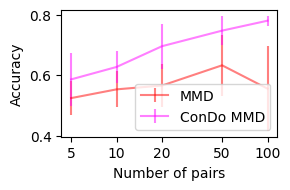

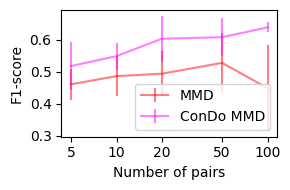

In [8]:
for metricname, metric in [('Accuracy', accs), ('F1-score', f1s)]: 
    plt.figure(figsize=(3,2));
    color_dict = {'MMD': 'red', 'ConDo MMD': 'magenta'}
    for mname, _ in minfos:
        cur_vals = [metric[n_pairs][mname] for n_pairs in n_pairs_list]
        plt.errorbar(
            n_pairs_list,
            [np.mean(cur) for cur in cur_vals],
            [np.std(cur) for cur in cur_vals],
            label=mname, color=color_dict[mname], alpha=0.5,
        );
    plt.xscale('log');
    plt.xticks(n_pairs_list, n_pairs_list);
    plt.minorticks_off();
    plt.ylabel(metricname);
    plt.xlabel('Number of pairs');
    plt.legend(loc='lower right');
    plt.tight_layout();
    plt.savefig(f'SNAREseq-{metricname}-tabpfnOnAdapted.pdf');

In [9]:
"""
pair_labels = np.unique(np.concatenate([Ys, Yt]))
n_total_pairs = pair_labels.size
saccs = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
sf1s = {n_pairs: {mname: [] for mname, _ in minfos} for n_pairs in n_pairs_list}
clf = TabPFNClassifier()
for rix in range(num_random):
    rng = skut.check_random_state(rix)
    clf_train_pairlabels = rng.choice(pair_labels, size=clf_train, replace=False)
    clf_train_sixs = (Ys == clf_train_pairlabels).any(axis=1).nonzero()
    remaining_pairlabels = np.setdiff1d(pair_labels, clf_train_pairlabels)

    for n_pairs in n_pairs_list:
    clf.fit(Xs, Zs.ravel(), overwrite_warning=True)

        cur_pairs_labels = rng.choice(pair_labels, size=n_pairs, replace=False)
        cur_sixs, = (Ys == cur_pairs_labels).any(axis=1).nonzero()
        cur_tixs, = (Yt == cur_pairs_labels).any(axis=1).nonzero()
        for mname, mfunc in minfos:
            adapter = mfunc()
            if 'ConDo' in mname:
                adapter.fit(Xt[cur_tixs, :], Xs[cur_sixs, :], Zt[cur_tixs, :], Zs[cur_sixs, :])
            else:
                adapter.fit(Xt[cur_tixs, :], Xs[cur_sixs, :])
            adaptX = adapter.transform(Xt)           
            pred_tgt = clf.predict(adaptX)
            saccs[n_pairs][mname].append(accuracy_score(pred_tgt, Zt.ravel()))
            sf1s[n_pairs][mname].append(f1_score(pred_tgt, Zt.ravel(), average='macro'))
""";

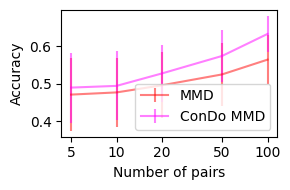

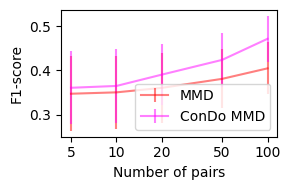

In [10]:
for metricname, metric in [('Accuracy', saccs), ('F1-score', sf1s)]: 
    plt.figure(figsize=(3,2));
    color_dict = {'MMD': 'red', 'ConDo MMD': 'magenta'}
    for mname, _ in minfos:
        cur_vals = [metric[n_pairs][mname] for n_pairs in n_pairs_list]
        plt.errorbar(
            n_pairs_list,
            [np.mean(cur) for cur in cur_vals],
            [np.std(cur) for cur in cur_vals],
            label=mname, color=color_dict[mname], alpha=0.5,
        );
    plt.xscale('log');
    plt.xticks(n_pairs_list, n_pairs_list);
    plt.minorticks_off();
    plt.ylabel(metricname);
    plt.xlabel('Number of pairs');
    plt.legend(loc='lower right');
    plt.tight_layout();
    plt.savefig(f'SNAREseq-{metricname}-tabpfnOnOriginal.pdf');